# Reading and editing a topography
A topograph/bathymetry is needed to create the domain of interpolation (land-sea mask). The topography/bathymetry is usually extracted from a netCDF file.     
Adapted topographies:
* General Bathymetric Chart of the Oceans ([GEBCO](https://www.gebco.net/))
* [EMODnet Bathymetry](http://www.emodnet-bathymetry.eu)
* Other topographies can be used as long as they define the netCDF variables `lon`, `lat` and `bat` (positive above sea-level and negative below, in `DIVAnd` however, the convention is that `z` is positive in sea water).

This notebook illustrates how the land-sea mask can be modified, for example to exclude a lake.


![mask](./Images/2020-01-12-more-prime-images-1.png)

This 7500 digits long number in binary is actually a prime number ([Gilles Esposito-Farèse](http://www.gef.free.fr/oulipo34.html#date060120)).

In [28]:
using DIVAnd
using PyPlot
using Dates
using Statistics
using CairoMakie
using GeoMakie
include("../config.jl")

"https://dox.uliege.be/index.php/s/h8d3pyqmuea6J9H/download"

The full EMODnet Bathymetry is a quite big file (~1GB) that can be obtained from the bathymetry portal: http://portal.emodnet-bathymetry.eu/?menu=19. In the present notebook, we will work with the GEBCO bathymetry with a resolution that has been decreased.

Note that an extremely fine bathymetry is only necessary when working on small, regional domains.

## Data download and domain selection
We create a domain encompassing the north of Corsica.     
The bathymetry file is automatically downloaded (if not already present).

In [29]:
dx = dy = 0.125
lonr = 2.5:dx:12.
latr = 42.3:dy:44.6

bathname = gebco08file
download_check(gebco08file, gebco08fileURL)
bathisglobal = true;

[ Info: File already downloaded


We have two main tools to load the bathymetry:
1. `DIVAnd.extract_bath` loads the bathymetry at the resolution defined in the netCDF file while 
2. `DIVAnd.load_bath` reduces the resolution to match the resolution of the analysis.

### Extract bathymetry

In [30]:
?extract_bath

search: extract_bath AbstractMatch @extractvalue @extract load_bath



```
bx,by,b = DIVAnd.extract_bath(bath_name,isglobal,xi,yi)
```

Extract the bathymetry from the NetCDF file `bathname`. The parameter `isglobal` is true if the NetCDF file covers the whole globe and thus the last longitude point can be considered to be right next to the first longitude point. `xi` and `yi` are vectors defining the bounding box of the data. No interpolation is performed.

**Convention:** b is positive in the water and negative in the air.

The NetCDF file is expected to have the one dimensional variables `lon` and `lat` with the longitude (degrees East) and latitude (degrees North) and the two dimentional array `bat` with the digital terrain model (negative in water and positive above water). The order of the dimension should follow be: longitude and then latitude in [Column-major ordering](https://en.wikipedia.org/wiki/Row-_and_column-major_order) (or latitude and then longitude if the tool `ncdump` is used, which is based on Row-major ordering).

Example of the output of `ncdump -h`:

```
netcdf gebco_30sec_8 {
dimensions:
     lat = 2702 ;
     lon = 5400 ;
variables:
     double lat(lat) ;
          lat:long_name = "Latitude" ;
          lat:standard_name = "latitude" ;
          lat:units = "degrees_north" ;
     double lon(lon) ;
          lon:long_name = "Longitude" ;
          lon:standard_name = "longitude" ;
          lon:units = "degrees_east" ;
     float bat(lat, lon) ;
          bat:long_name = "elevation above sea level" ;
          bat:standard_name = "height" ;
          bat:units = "meters" ;

// global attributes:
          :title = "GEBCO" ;
}
```


In [31]:
bx,by,b = extract_bath(bathname,true,lonr,latr)
@show size(b);

size(b) = (75, 21)


In [34]:
?GeoAxis

search: GeoAxis OldAxis Axis GeoMakie



**`GeoMakie.GeoAxis <: Block`**

No docstring defined.

**Attributes**

(type `?GeoMakie.GeoAxis.x` in the REPL for more information about attribute `x`)

`alignmode`, `aspect`, `autolimitaspect`, `dest`, `fonts`, `halign`, `height`, `limits`, `panbutton`, `source`, `subtitle`, `subtitlecolor`, `subtitlefont`, `subtitlegap`, `subtitlelineheight`, `subtitlesize`, `subtitlevisible`, `tellheight`, `tellwidth`, `title`, `titlealign`, `titlecolor`, `titlefont`, `titlegap`, `titlelineheight`, `titlesize`, `titlevisible`, `valign`, `width`, `xautolimitmargin`, `xaxisposition`, `xgridcolor`, `xgridstyle`, `xgridvisible`, `xgridwidth`, `xlabel`, `xlabelcolor`, `xlabelfont`, `xlabelpadding`, `xlabelrotation`, `xlabelsize`, `xlabelvisible`, `xminorgridcolor`, `xminorgridstyle`, `xminorgridvisible`, `xminorgridwidth`, `xminortickalign`, `xminortickcolor`, `xminorticks`, `xminorticksize`, `xminorticksvisible`, `xminortickwidth`, `xpankey`, `xpanlock`, `xrectzoom`, `xreversed`, `xscale`, `xtickalign`, `xtickcolor`, `xtickformat`, `xticklabelalign`, `xticklabelcolor`, `xticklabelfont`, `xticklabelpad`, `xticklabelrotation`, `xticklabelsize`, `xticklabelspace`, `xticklabelsvisible`, `xticks`, `xticksize`, `xticksvisible`, `xtickwidth`, `xzoomkey`, `xzoomlock`, `yautolimitmargin`, `yaxisposition`, `ygridcolor`, `ygridstyle`, `ygridvisible`, `ygridwidth`, `ylabel`, `ylabelcolor`, `ylabelfont`, `ylabelpadding`, `ylabelrotation`, `ylabelsize`, `ylabelvisible`, `yminorgridcolor`, `yminorgridstyle`, `yminorgridvisible`, `yminorgridwidth`, `yminortickalign`, `yminortickcolor`, `yminorticks`, `yminorticksize`, `yminorticksvisible`, `yminortickwidth`, `ypankey`, `ypanlock`, `yrectzoom`, `yreversed`, `yscale`, `ytickalign`, `ytickcolor`, `ytickformat`, `yticklabelalign`, `yticklabelcolor`, `yticklabelfont`, `yticklabelpad`, `yticklabelrotation`, `yticklabelsize`, `yticklabelspace`, `yticklabelsvisible`, `yticks`, `yticksize`, `yticksvisible`, `ytickwidth`, `yzoomkey`, `yzoomlock`


In [65]:
function plot_bathy(bx, by, b)
    fig = GeoMakie.Figure()
    ga = GeoAxis(fig[1, 1];  dest = "+proj=merc", title = "GEBCO bathymetry", xticks=2.:1.:14, yticks=42.:1.:45.)
    hm = GeoMakie.heatmap!(ga, bx, by, b, interpolate = false)
    GeoMakie.xlims!(ga, (bx[1], bx[end]))
    GeoMakie.ylims!(ga, (by[1], by[end]))
    GeoMakie.contour!(ga, bx, by, b, levels=[0.], color=:black)
    Colorbar(fig[2, 1], hm, vertical = false, label = "(m)")
    fig
end

plot_bathy (generic function with 1 method)

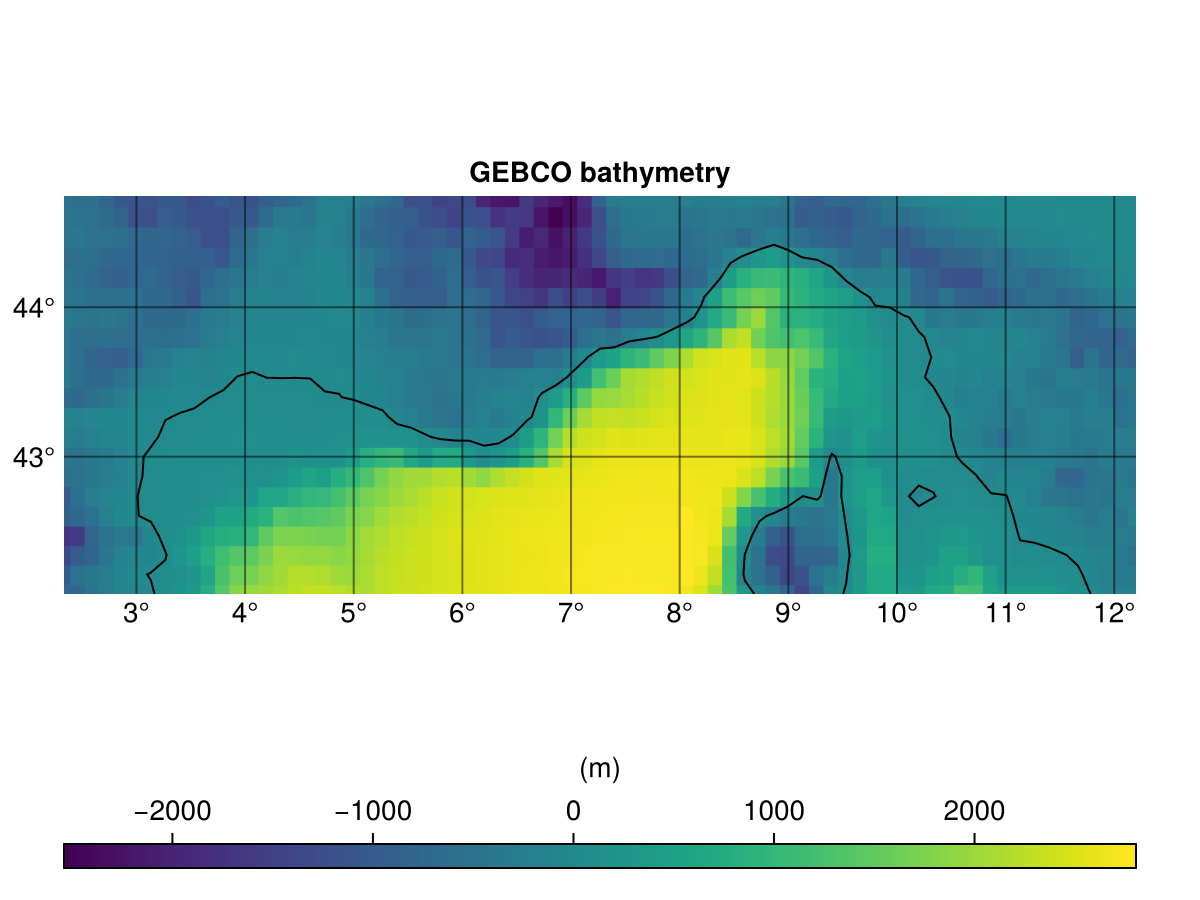

In [66]:
plot_bathy(bx, by, b)

### Load bathymetry
With a change of its original resolution

In [7]:
?load_bath

search: load_bath Base.load_path load_mask loadobs extract_bath



```
xi,yi,bath = DIVAnd.load_bath(bath_name,isglobal,xi,yi)
```

Load the bathymetry from the netCDF file `bathname`. The parameter `isglobal` is true if the NetCDF file covers the whole globe and thus the last longitude point can be considered to be right next to the first longitude point. `xi` and `yi` are vectors containing the longitude and latitude grid onto which the bathymetry should be interpolated.


In [8]:
bx,by,b = load_bath(bathname,true,lonr,latr)

pcolor(bx,by,b'); 
colorbar(orientation="horizontal")
gca().set_aspect(1/cos(mean([ylim()...]) * pi/180))

@show size(b)

LoadError: UndefVarError: `bathname` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

## Mask creation
We start by defining the mask as a 3D matrix containing only `False`, then we set the values to `True` when the actual depth is deeper than the selected values stored in the vector `depthr`.

In [9]:
depthr = [0,10,20,500]
mask = falses(size(b,1),size(b,2),length(depthr))

for k = 1:length(depthr)
    for j = 1:size(b,2)
        for i = 1:size(b,1)
            mask[i,j,k] = b[i,j] >= depthr[k]
        end
    end
end
@show typeof(mask)

LoadError: UndefVarError: `b` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [10]:
pcolor(bx,by,Float64.(mask[:,:,1]'), cmap=PyPlot.cm.binary_r)
colorbar(orientation="horizontal")
gca().set_aspect(1/cos(mean([ylim()...]) * pi/180)) # fixes the aspect ratio

LoadError: UndefVarError: `bx` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

Another solution is to use the `load_mask` function:

In [11]:
xmask,ymask,mmask = load_mask(bathname,true,lonr,latr,depthr);

LoadError: UndefVarError: `bathname` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [12]:
pcolor(xmask,ymask,Float64.(mask[:,:,1]'), cmap=PyPlot.cm.binary_r)
colorbar(orientation="horizontal")
gca().set_aspect(1/cos(mean([ylim()...]) * pi/180)) # fixes the aspect ratio

LoadError: UndefVarError: `xmask` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [13]:
mask[3,3,1] = true
pcolor(Float64.(mask[:,:,1])', cmap=PyPlot.cm.binary_r)
colorbar(orientation="horizontal")
gca().set_aspect(1/cos(mean([ylim()...]) * pi/180)) # fixes the aspect ratio

LoadError: UndefVarError: `mask` not defined in `Main`
Suggestion: check for spelling errors or missing imports.
Hint: a global variable of this name may be made accessible by importing VectorizationBase in the current active module Main

## Flood filling
This tool allows user to remove small lakes or islands.

In [14]:
?DIVAnd.floodfill

!!! warning
    The following bindings may be internal; they may change or be removed in future versions:

      * `DIVAnd.floodfill`


```
label = floodfill(mask)
```

Attribute an integer number (a numeric label) to every element in mask such that all grid points connected by a von Neumann neighborhood (without crossing elements which are `false` in mask) have the same label. Labels are sorted such that the label 1 corresponds to the largest area, label 2 the 2nd largest and so on.


In [15]:
label = DIVAnd.floodfill(mask)
pcolor(label[:,:,1]')
colorbar(orientation="horizontal")
gca().set_aspect(1/cos(mean([ylim()...]) * pi/180)) # fixes the aspect ratio

LoadError: UndefVarError: `mask` not defined in `Main`
Suggestion: check for spelling errors or missing imports.
Hint: a global variable of this name may be made accessible by importing VectorizationBase in the current active module Main

In [16]:
mask3 = label .== 1
pcolor(Float64.(mask3[:,:,1])', cmap=PyPlot.cm.binary_r)
colorbar(orientation="horizontal")
gca().set_aspect(1/cos(mean([ylim()...]) * pi/180)) # fixes the aspect ratio

LoadError: UndefVarError: `label` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

## Mask editing
To edit the mask, you can either modify directly its values if you know the indices, or you can use a selection based on the coordinates.
### Create an artificial island
We simply modify the mask at a given location.

In [17]:
# Create a copy of the mask for ediding
mask_copy = copy(mask);
mask_copy[63,8,:] .= false;

LoadError: UndefVarError: `mask` not defined in `Main`
Suggestion: check for spelling errors or missing imports.
Hint: a global variable of this name may be made accessible by importing VectorizationBase in the current active module Main

In [18]:
pcolor(bx, by, Float64.(mask_copy[:,:,1]'), cmap=PyPlot.cm.binary_r)
colorbar(orientation="horizontal")
gca().set_aspect(1/cos(mean([ylim()...]) * pi/180))

LoadError: UndefVarError: `bx` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

### Remove an island (based on indices)

In [19]:
mask_copy = copy(mask);
mask_copy[48:59,1:10,:] .= true;

LoadError: UndefVarError: `mask` not defined in `Main`
Suggestion: check for spelling errors or missing imports.
Hint: a global variable of this name may be made accessible by importing VectorizationBase in the current active module Main

In [20]:
pcolor(bx, by, Float64.(mask_copy[:,:,1]'), cmap=PyPlot.cm.binary_r)
colorbar(orientation="horizontal")
gca().set_aspect(1/cosd(mean(ylim())))
#[ylim()...]

LoadError: UndefVarError: `bx` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

### Remove an island (based on coordinates). 

This is the recommended approach as you can change resolution easily
`sel_lon` and `sel_lat` are obtained by checking the longitude and latitudes.

In [21]:
mask_copy = copy(mask);
sel_lon = (bx.>8) .& (bx.<10.);
sel_lat = (by.<43.25);
mask_copy[sel_lon, sel_lat, :] .= true;
pcolor(bx, by, Float64.(mask_copy[:,:,1]'), cmap=PyPlot.cm.binary_r); 
colorbar(orientation="horizontal")
gca().set_aspect(1/cos(mean([ylim()...]) * pi/180))

LoadError: UndefVarError: `mask` not defined in `Main`
Suggestion: check for spelling errors or missing imports.
Hint: a global variable of this name may be made accessible by importing VectorizationBase in the current active module Main

In [22]:
@show sel_lon;

LoadError: UndefVarError: `sel_lon` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

### Removing isolated sea pixels
Let's edit the previous mask and add an isolated sea point in the western part of the domain.    

In [23]:
mask[3,3,1] = true
pcolor(Float64.(mask[:,:,1])')
colorbar(orientation="horizontal")
gca().set_aspect(1/cos(mean([ylim()...]) * pi/180)) # fixes the aspect ratio

LoadError: UndefVarError: `mask` not defined in `Main`
Suggestion: check for spelling errors or missing imports.
Hint: a global variable of this name may be made accessible by importing VectorizationBase in the current active module Main

The function `floofill` can help us identify the position of this pixel:

In [24]:
?DIVAnd.floodfill

!!! warning
    The following bindings may be internal; they may change or be removed in future versions:

      * `DIVAnd.floodfill`


```
label = floodfill(mask)
```

Attribute an integer number (a numeric label) to every element in mask such that all grid points connected by a von Neumann neighborhood (without crossing elements which are `false` in mask) have the same label. Labels are sorted such that the label 1 corresponds to the largest area, label 2 the 2nd largest and so on.


Let's plot the `label` values as obtained by the execution of `floodfill`:

In [25]:
label = DIVAnd.floodfill(mask)
pcolor(label[:,:,1]')
colorbar(orientation="horizontal")
gca().set_aspect(1/cos(mean([ylim()...]) * pi/180)) # fixes the aspect ratio

LoadError: UndefVarError: `mask` not defined in `Main`
Suggestion: check for spelling errors or missing imports.
Hint: a global variable of this name may be made accessible by importing VectorizationBase in the current active module Main

We see that the isolated sea point is characterised by `label = 2`,        
hence we can discard it by taking the cells for which `label = 1`.

In [26]:
mask3 = label .== 1
pcolor(Float64.(mask3[:,:,1])')
colorbar(orientation="horizontal")
gca().set_aspect(1/cos(mean([ylim()...]) * pi/180)) # fixes the aspect ratio

LoadError: UndefVarError: `label` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

## Exercice
1. Load the bathymetry around the Black Sea.
2. Create a land sea mask for the following levels: 0, 150, 500 and 1000 meters.
3. Remove the Sea of Azov and the Sea of Marmara.
4. Plot the result.

The solution is available in [06-topography-BlackSea](./solutions/06-topography-BlackSea.ipynb) and should look like this:

<img src="./Images/BlackSea_mask.png" width="250px">

# Adapt your own bathymetry (advanced)

To use a local bathymetry, one needs to create a netCDF file which has a similar structure than GEBCO files.
In particular, the netCDF file is expected to have the one-dimensional variables `lon` (longitude in _degrees East_) and `lat` (latitude in _degrees North_), and the two-dimentional array `bat` containing the digital terrain model (negative in water and positive above water). 

The order of the dimensions should be: longitude and then latitude in *Column-major* ordering (or latitude and then longitude if the tool ncdump is used, which is based on *Row-major* ordering).

The module `NCDatasets`, provide the utility function `ncgen` which returns the Julia code that creates a netCDF file with the same metadata:

In [27]:
using NCDatasets
ncgen(bathname)

LoadError: UndefVarError: `bathname` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In this example, one would need to adapt:
* the title attribute of the NetCDF file 
* the size of the dimensions
* define the variables `nclon`, `nclat` and `ncbat`

With this code, you only have to use the coordinates and the bathymetry read from your own file to generate the new bathymetry file.